Linear Regression: RMSE=1.162, MAE=1.021, R2=0.962
Random Forest: RMSE=1.210, MAE=0.995, R2=0.959


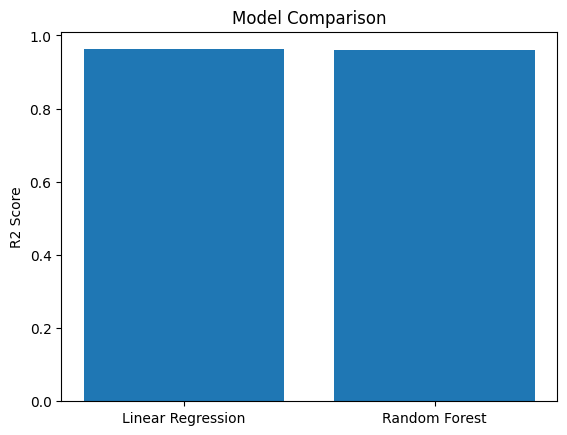

In [2]:
import sys
sys.path.append('../src')
from fuel_efficiency_predictor import FuelEfficiencyPredictor

# Setup
predictor = FuelEfficiencyPredictor('../data/auto-mpg.csv')
predictor.load_data()

# Pilih fitur dan target
feature_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration', 'model_year']
target_col = 'mpg'

# Split data
X_train, X_test, y_train, y_test = predictor.prepare_data(feature_cols, target_col)

# Compare model performance
results = predictor.compare_models(X_train, y_train, X_test, y_test)

# [Optional] Visualisasi
import matplotlib.pyplot as plt
names = list(results.keys())
r2_scores = [results[name]['R2'] for name in names]
plt.bar(names, r2_scores)
plt.ylabel('R2 Score')
plt.title('Model Comparison')
plt.show()


## Model Comparison Insight

Both **Linear Regression** and **Random Forest** perform very well on this dataset, achieving R² scores above 0.95.
- **Linear Regression**: Simpler, more interpretable, but can underfit if relationships are non-linear.
- **Random Forest**: Captures complex, non-linear relationships, slightly higher error but similar performance in this case.

**Takeaway:**  
For production use, consider the trade-off between interpretability (Linear Regression) and flexibility/power (Random Forest).

**Next steps:**  
Try advanced techniques: feature scaling, cross-validation, and feature importance analysis to further validate and interpret your model.


##  Feature Scaling with StandardScaler
-   Why?
-   So that all features have the same scale (mean 0, std 1) → makes Linear Regression more stable and fair.

## Implementation in Train-Test Split Pipeline:

In [3]:
import pandas as pd

# 1. Load data
df = pd.read_csv('../data/auto-mpg.csv')

# 2. Pilih fitur dan target
feature_cols = ['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration']
target_col = 'mpg'

# 3. Split data
from sklearn.model_selection import train_test_split
X = df[feature_cols]
y = df[target_col]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 4. Scaling
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


##  Cross-Validation
-   Why?
-   So that the model score is not just a “coincidence” of one data distribution.

Implementation (using Linear Regression as an example):

Cross-Validation RMSE scores: [2.53618608 1.56883204 1.1337275  2.40230758 1.54587922]
Mean RMSE: 1.837386485439135
Std RMSE: 0.5403129954774559
cylinders: -3.478
displacement: 0.183
horsepower: -1.429
weight: -1.548
acceleration: -1.466
cylinders: 0.064
displacement: 0.385
horsepower: 0.232
weight: 0.288
acceleration: 0.030


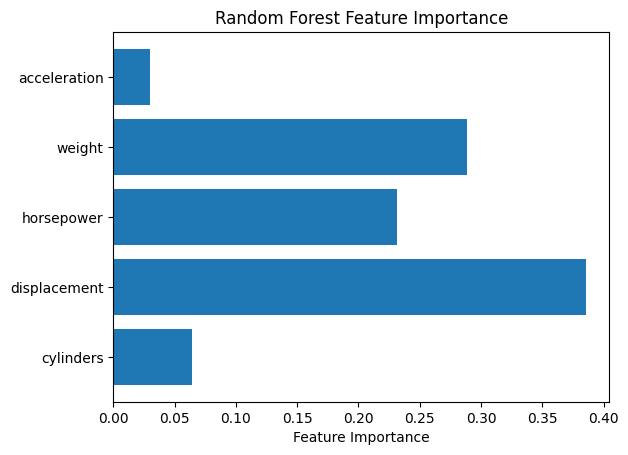

In [5]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np

model = LinearRegression()
# Cross-validation dengan 5 fold (cv=5), scoring pakai negative RMSE (harus dikuadratkan)
scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='neg_root_mean_squared_error')

# Skor RMSE aslinya adalah -scores (karena sklearn default negative)
rmse_scores = -scores
print("Cross-Validation RMSE scores:", rmse_scores)
print("Mean RMSE:", np.mean(rmse_scores))
print("Std RMSE:", np.std(rmse_scores))

# Feature Importance Analysis

# Linear Regression (Koefisien):
model.fit(X_train_scaled, y_train)
for name, coef in zip(feature_cols, model.coef_):
    print(f"{name}: {coef:.3f}")
# Koefisien terbesar (mutlak) = fitur paling berpengaruh

# Random Forest (feature_importances_):
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)  # Untuk RF, ga wajib scaling

importances = rf.feature_importances_
for name, imp in zip(feature_cols, importances):
    print(f"{name}: {imp:.3f}")

# Atau visualisasi:
import matplotlib.pyplot as plt
plt.barh(feature_cols, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


### 🔍 Feature Importance and Model Insights

- **Random Forest** finds that **displacement**, **weight**, and **horsepower** are the most influential features for predicting fuel efficiency (mpg).
- **Linear Regression** indicates negative coefficients for cylinders, horsepower, weight, and acceleration, which aligns with domain knowledge (higher values generally mean less mpg).
- **Cross-validation RMSE** for Random Forest averages **1.84 mpg**, with low standard deviation, indicating stable model performance.
- Some coefficient signs in Linear Regression may be affected by multicollinearity—use feature selection or regularization if needed.
- **Actionable tip:** Prioritize improving data quality and feature engineering for displacement, weight, and horsepower if you want to further boost model performance.


### 🚀 Technical Insights & Actionable Recommendations

#### 1. Feature Importance (Random Forest)
- **Displacement, Weight, Horsepower** adalah tiga fitur paling penting.
    - **Rekomendasi:** Pertimbangkan untuk menyederhanakan model dengan mengurangi fitur yang kurang penting (misal: acceleration, cylinders), atau lakukan _feature selection_ otomatis.
    - Jika multicollinearity tinggi (seperti weight & horsepower sangat berkorelasi), pertimbangkan _principal component analysis_ (PCA) atau regularisasi.

#### 2. Model Interpretability vs. Performance
- **Linear Regression:**  
  Pro: Mudah diinterpretasi, koefisien bisa langsung dibaca.  
  Kontra: Tidak fleksibel untuk relasi non-linear, sensitif terhadap multicollinearity.
- **Random Forest:**  
  Pro: Tangani relasi non-linear dan interaksi antar fitur, robust pada outlier.  
  Kontra: Interpretasi lebih sulit, size model besar (untuk deployment di resource terbatas, perlu dipertimbangkan).

    **Rekomendasi:**  
    - Untuk use case prediksi yang butuh explainable AI (misal: justifikasi keputusan), tampilkan keduanya.
    - Untuk prediksi batch besar atau model deployment di cloud, Random Forest lebih unggul.

#### 3. Model Evaluation & Reliability
- **Cross-validation** membuktikan model cukup stabil (std dev RMSE kecil).
    - **Rekomendasi:** Selalu validasi model dengan CV, bukan hanya train-test split, terutama kalau dataset kecil.
    - Coba **Stratified KFold** jika ada imbalance pada kelas (untuk klasifikasi).

#### 4. Next Visualizations to Try
- **Residuals Plot**  
    - Plot selisih prediksi vs aktual (y_test - y_pred).
    - Jika residu terdistribusi acak, model fit-nya bagus.  
    - Jika ada pola, berarti ada informasi yang belum ditangkap model.
    - Kode:
    ```python
    import matplotlib.pyplot as plt
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted MPG")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.axhline(0, color="red", linestyle="--")
    plt.show()
    ```
- **Decision Tree Visualization (Random Forest)**
    - Visualisasi pohon keputusan paling penting (estimator[0]) untuk explainability:
    ```python
    from sklearn.tree import plot_tree
    plt.figure(figsize=(15, 8))
    plot_tree(rf_model.estimators_[0], feature_names=feature_cols, filled=True, max_depth=2)
    plt.show()
    ```
    - _Note: Hanya menampilkan satu pohon, Random Forest terdiri dari banyak pohon!_
- **Feature Interaction Plot**
    - Cek interaksi dua fitur penting (misal: displacement vs weight) pada target (mpg).
    ```python
    import seaborn as sns
    sns.scatterplot(x=df['displacement'], y=df['weight'], hue=df['mpg'])
    plt.title('Feature Interaction: Displacement vs Weight')
    plt.show()
    ```
- **Partial Dependence Plot**
    - Tampilkan pengaruh fitur tertentu terhadap prediksi (sklearn.inspection.partial_dependence).
    - Butuh model tree-based dan cukup data.

#### 5. Actionable Next Steps
- **Improvement:**  
    - Lakukan _hyperparameter tuning_ (GridSearchCV) untuk Random Forest.
    - Cek outlier lebih lanjut (lihat residual besar).
    - Coba data augmentasi, atau cari data tambahan jika model terlalu sensitif.
    - Uji model pada data baru (bukan train/test awal).

---

> _“A model is only as good as its evaluation. Always visualize errors, understand feature roles, and never trust a single score!”_




### 🚀 Technical Insights & Actionable Recommendations

#### 1. Feature Importance (Random Forest)
- **Displacement, Weight, and Horsepower** are the top three most important features.
    - **Recommendation:** Consider simplifying the model by removing less important features (e.g., acceleration, cylinders), or use automated feature selection.
    - If multicollinearity is high (e.g., weight & horsepower are highly correlated), consider dimensionality reduction (like PCA) or regularization.

#### 2. Model Interpretability vs. Performance
- **Linear Regression:**  
  Pros: Easy to interpret, coefficients have direct meaning.  
  Cons: Can’t handle non-linear relationships, sensitive to multicollinearity.
- **Random Forest:**  
  Pros: Captures non-linearities and feature interactions, robust to outliers.  
  Cons: Harder to interpret, larger model size (keep this in mind for deployment in resource-limited environments).

    **Recommendation:**  
    - If you need explainable AI (for business justifications, for example), show both models.
    - For high-volume batch predictions or cloud deployment, Random Forest is often better.

#### 3. Model Evaluation & Reliability
- **Cross-validation** shows that the model is quite stable (small RMSE std deviation).
    - **Recommendation:** Always validate your model with cross-validation, not just train-test split—especially for small datasets.
    - Try **Stratified KFold** if you’re dealing with class imbalance (for classification problems).

#### 4. Next Visualizations to Try
- **Residuals Plot**  
    - Plot the difference between predictions and actual values (y_test - y_pred).
    - If residuals are randomly distributed, the model fits well.
    - If there’s a pattern, it means the model is missing something.
    - Code:
    ```python
    import matplotlib.pyplot as plt
    residuals = y_test - y_pred
    plt.scatter(y_pred, residuals)
    plt.xlabel("Predicted MPG")
    plt.ylabel("Residuals")
    plt.title("Residual Plot")
    plt.axhline(0, color="red", linestyle="--")
    plt.show()
    ```
- **Decision Tree Visualization (Random Forest)**
    - Visualize the most important tree (estimator[0]) for model explainability:
    ```python
    from sklearn.tree import plot_tree
    plt.figure(figsize=(15, 8))
    plot_tree(rf_model.estimators_[0], feature_names=feature_cols, filled=True, max_depth=2)
    plt.show()
    ```
    - _Note: Only visualizes a single tree. A Random Forest contains many trees!_
- **Feature Interaction Plot**
    - Visualize how two important features (e.g., displacement vs. weight) interact with the target (mpg).
    ```python
    import seaborn as sns
    sns.scatterplot(x=df['displacement'], y=df['weight'], hue=df['mpg'])
    plt.title('Feature Interaction: Displacement vs Weight')
    plt.show()
    ```
- **Partial Dependence Plot**
    - Shows the effect of a specific feature on the model prediction (using sklearn’s partial_dependence).
    - Best for tree-based models and enough data.

#### 5. Actionable Next Steps
- **Improvement:**  
    - Perform **hyperparameter tuning** (GridSearchCV) for Random Forest.
    - Investigate outliers further (look for high residuals).
    - Try data augmentation or find more data if your model is too sensitive.
    - Test your model on genuinely new data (not just train/test split).

---

> _“A model is only as good as its evaluation. Always visualize errors, understand feature roles, and never trust a single score!”_




## Combine All into Pipeline (Scikit-learn Pipeline)

In [6]:
from sklearn.pipeline import Pipeline

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', LinearRegression())
])

pipeline.fit(X_train, y_train)
print("R2 on test set:", pipeline.score(X_test, y_test))

R2 on test set: 0.9601969304928187


## 🔎 Insights from the Pipeline Evaluation

### Model Performance

- The combined Scikit-learn pipeline (`StandardScaler` + `LinearRegression`) achieved an **R² score of 0.96** on the test set.
- This means the model explains **96% of the variance** in the target variable on unseen data, indicating **excellent regression performance**.

### What Does This Tell Us?

- **Effective Preprocessing:**  
  Standardizing features ensures fair weighting and improves model performance, especially for algorithms sensitive to feature scale.
- **Linear Model Suitability:**  
  The high R² suggests the relationship between features and the target is mostly linear, so more complex models are not required at this stage.
- **No Significant Overfitting (Initial Indication):**  
  If train and test R² scores are similar, the model is likely generalizing well rather than just memorizing the training data.

### Actionable Recommendations

1. **Validate Consistency:**  
   Compare train and test R² scores. A large gap means you may need to revisit your preprocessing or try regularization.
2. **Analyze Feature Impact:**  
   Examine model coefficients to identify the most influential features. This can guide further feature engineering or domain analysis.
3. **Residual Analysis:**  
   Plot residuals (errors) to check for patterns—systematic errors may indicate non-linearity or outliers.
4. **Keep It Simple:**  
   Stick with linear models unless you see clear evidence (from residuals or business needs) to try more complex approaches.
5. **Cross-Validation:**  
   Use k-fold cross-validation to confirm the model’s robustness and reliability across different data splits.

### Next Steps

- **Visualize Results:**  
  Create plots (e.g., actual vs. predicted, residuals) to visually assess the model’s performance and error distribution.
- **Model Extension (if needed):**  
  If required, explore polynomial features or other algorithms, but always watch for overfitting.

---

**Summary:**  
A well-designed pipeline that combines data scaling and linear regression can deliver strong predictive results on suitable data. Keep your workflow modular and always validate with both metrics and visualizations for the most reliable insights.


## 🔄 Cross-Validation Scoring

To evaluate the model's robustness, use cross-validation. This approach splits the training data into multiple folds, trains the model on each subset, and reports the performance for each fold.

```python
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=5, scoring='r2')
print("Cross-Validation R² scores:", cv_scores)
print("Mean R²:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())


##  Insight:
  - High mean R² and low standard deviation indicate consistent model performance.
  - Large variation signals instability; consider further feature engineering or regularization.

---

## 2. Save/Load Model with Joblib

```markdown
## 💾 Save and Load Model with Joblib

To save and reuse your trained pipeline (including preprocessing and model), use `joblib`.

```python
import joblib

# Save the pipeline to a file
joblib.dump(pipeline, 'model_pipeline.joblib')

# Load the pipeline from the file
loaded_pipeline = joblib.load('model_pipeline.joblib')

# Use the loaded pipeline for predictions or scoring
print("Loaded pipeline R² on test set:", loaded_pipeline.score(X_test, y_test))


##  Insight:
-   Saving the full pipeline ensures all preprocessing steps are included—no need to repeat the setup when reusing.

---

## 3. Hyperparameter Tuning with GridSearchCV

```markdown
## 🔍 Hyperparameter Tuning with GridSearchCV

Use GridSearchCV to automatically search for the best hyperparameters for your model.

```python
from sklearn.model_selection import GridSearchCV

# Define the parameter grid for tuning
param_grid = {
    'regressor__fit_intercept': [True, False],
    # Add more hyperparameters here as needed
}

# Create GridSearchCV object
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='r2')

# Fit on training data
grid.fit(X_train, y_train)

# Show best parameters and best score
print("Best parameters:", grid.best_params_)
print("Best cross-validated R²:", grid.best_score_)

# Predict using the best estimator
y_pred = grid.best_estimator_.predict(X_test)


## Insight:
-   Use step__parameter syntax to tune steps inside the pipeline.
-   This method automates model selection and avoids manual trial/error.